# ChEMBL: loading data from pt files

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
class XyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

def dataloader_from_file(path, **kwargs):
    pIC50 = torch.load(path)
    X = torch.empty((len(pIC50), len(pIC50[0][0])))
    y = torch.empty((len(pIC50), 1))
    for i, (x_, y_) in enumerate(pIC50):
        X[i] = x_
        y[i] = y_
    return DataLoader(XyDataset(X, y), **kwargs)

In [5]:
from kinoml.ml.torch_models import NeuralNetworkRegression
from kinoml.core.measurements import pIC50Measurement, pKdMeasurement, pKiMeasurement
from tqdm.auto import trange, tqdm

paths = [
    "ChEMBL_pIC50Measurement.pt",
    "ChEMBL_pKdMeasurement.pt",
    "ChEMBL_pKiMeasurement.pt"
]

obsmodels = [
    pIC50Measurement._observation_model_pytorch,
    pKdMeasurement._observation_model_pytorch,
    pKiMeasurement._observation_model_pytorch,
]

In [3]:
loaders = [dataloader_from_file(p, batch_size=64, shuffle=True) for p in paths]

In [4]:
# precompute input size
input_size = loaders[0].dataset.X.shape[1]
model = NeuralNetworkRegression(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss() # Mean squared error

In [5]:
nb_epoch = 100
loss_timeseries = []
ys = []
range_epochs = trange(nb_epoch, desc="Epochs (+ featurization...)")
for epoch in range_epochs:
    # Single cumulative loss / or loss per loader? look into this!
    cumulative_loss = 0.0
    ys.append([])
    for i, (loader, observation_model) in enumerate(zip(loaders, obsmodels)):
        for j, (x, y) in enumerate(loader):

            # Clear gradients
            optimizer.zero_grad()

            # Obtain model prediction given model input
            delta_g = model(x)

            # with observation model
            prediction = observation_model(delta_g)
            
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # !!! Make sure prediction and y match shapes !!!
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            
            y = y.reshape(prediction.shape)

            ys[-1].append((delta_g, prediction, y))

            # prediction = delta_g
            loss = loss_function(prediction, y)

            # Obtain loss for the predicted output
            # if cumulative loss is global, change this i to 0, or viceversa
            cumulative_loss += loss.item()

            # Gradients w.r.t. parameters
            loss.backward()

            # Optimizer
            optimizer.step()
            if j % 2000 == 0:    # print every 2000 mini-batches
                range_epochs.set_description(f"Epochs (loss={cumulative_loss / 2000:.2e})")
                cumulative_loss = 0.0
            
    loss_timeseries.append(cumulative_loss)

KeyboardInterrupt: 

Bad value in file PosixPath('/home/jaime/.conda/envs/kinoml-ci/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/bmh.mplstyle'), line 20 ("axes.prop_cycle: cycler('color', ['348ABD', 'A60628', '7A68A6', '467821', 'D55E00', 'CC79A7', '56B4E9', '009E73', 'F0E442', '0072B2'])"): Key axes.prop_cycle: 'cycler('color', ['348ABD', 'A60628', '7A68A6', '467821', 'D55E00', 'CC79A7', '56B4E9', '009E73', 'F0E442', '0072B2'])' is not a valid cycler construction: 


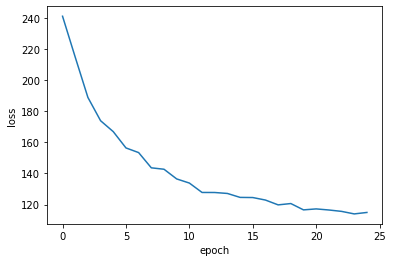

In [7]:
from matplotlib import pyplot as plt
f = plt.figure()
plt.plot(loss_timeseries)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [11]:
torch.save(model, "model.pt")

In [10]:
import numpy as np
from ipywidgets import interact
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def analyze(model, datafile):
    data = dataloader_from_file(datafile).dataset
    delta_g = model(data.X)
    prediction = obsmodels[0](delta_g).detach().numpy()


    fig, ax = plt.subplots()
    ax.scatter(prediction, data.y)
    ax.set(xlim=(0, 15), ylim=(0, 15))
    ax.set_xlabel("Predicted y")
    ax.set_ylabel("True y")
    ax.set_title(f"{datafile}: {len(data)//1000}k points")
    x = np.linspace(0, 15, 10)
    ax.plot(x, x)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

    r2 = r2_score(data.y, prediction)
    print(f"R2: Goodness of fit measure: {r2:.2f}")
    if all(elem==prediction[0] for elem in prediction):
        print("All outputs are equal: ")
    mse = mean_squared_error(data.y, prediction)
    mae = mean_absolute_error(data.y, prediction)
    rmse = np.sqrt(mse)
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

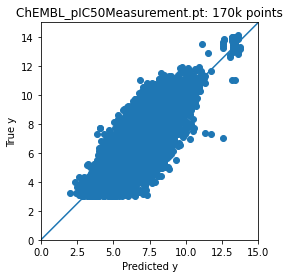

R2: Goodness of fit measure: 0.71
MSE: 0.48
RMSE: 0.69
MAE: 0.53


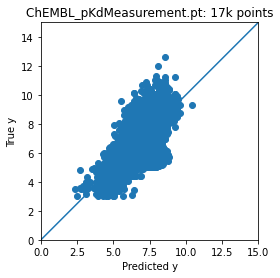

R2: Goodness of fit measure: 0.29
MSE: 0.96
RMSE: 0.98
MAE: 0.79


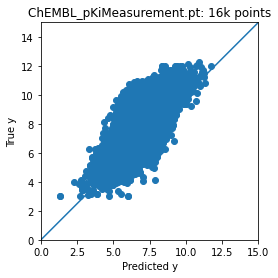

R2: Goodness of fit measure: 0.31
MSE: 1.38
RMSE: 1.18
MAE: 0.94


In [11]:
model = torch.load("model.pt")
for datafile in paths:
    analyze(model, datafile)